<span style="font-size: 14pt">ФИВТ, АПТ, Курс по машинному обучению, Весна 2018, семинар 2 </span>

<span style="color:blue; font-size: 12pt">Alexey Romanenko, </span>
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

<span style="color:black; font-size: 14pt">Plan</span>

* <span style="color:black"> Работа с признаками (30 минут) </span>
    * <span style="color:black"> Предобработка данных </span>
    * <span style="color:black"> Числовые и категориальные признаки </span>
    * <span style="color:orange"> Отбор признаков </span> (опционально)


* <span style="color:black"> Метрики (30 минут)</span>
    * <span style="color:black"> Метрики для Классификации </span>
    * <span style="color:black"> Метрики для Регрессии</span>
    * <span style="color:black"> Интпретация метрик со помощью вероятностного подхода </span>


* <span style="color:black"> Cross validation and bias-variance trade off (20 минут) </span>
    - <span style="color:black"> Проблема переобучения </span>
    - <span style="color:black"> Идея разложения ошибки на bias-variance</span>
    - <span style="color:black"> Bias и Variance</span>

<span style="color:black; font-size: 14pt">Key words</span>
   * <span style="color:black"> нормировка признаков, обработка пропусков</span>
   * <span style="color:black"> recall, precise, F2, MSE, MAE, MAPE  </span>
   * <span style="color:black"> отбор признаков, ADD-DELL, генетический алгоритм отбора признаков, полный перебор</span>
   * <span style="color:black"> bias-variance tradeoff (смещение и разброс) </span>

### Imports

In [1]:
from collections import Counter, defaultdict
from copy import deepcopy
from operator import itemgetter
from random import shuffle

import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from matplotlib import pylab, gridspec, pyplot as plt
from IPython.display import Image
import urllib


from sklearn.metrics import accuracy_score
from sklearn import metrics, neighbors, dummy, preprocessing, svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier


import matplotlib
%matplotlib inline

-------
<h1 align="center"> Работа с признаками </h1> 
# Предобработка данных

In [2]:
# Используются данные из https://archive.ics.uci.edu/ml/datasets/Adult
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header=None)
columns = ('age workclass fnlwgt education educ-num marital-status occupation relationship '
           'race sex capital-gain capital-loss  hours-per-week native-country salary')
df.columns = columns.split()

In [3]:
df.head()

,age,workclass,fnlwgt,education,educ-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


** Соотношение классов **

In [4]:
df.groupby('salary').count()[['age']]

,age
salary,
<=50K,24720
>50K,7841


### Перекодировка категориальных признаков

In [7]:
def number_encode_features(init_df):
    result = init_df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

encoded_data, encoders = number_encode_features(df)
encoded_data.head()

,age,workclass,fnlwgt,education,educ-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0


In [8]:
# Для того чтобы преобразовать фичи для новых объектов
encoders

{'education': LabelEncoder(),
 'marital-status': LabelEncoder(),
 'native-country': LabelEncoder(),
 'occupation': LabelEncoder(),
 'race': LabelEncoder(),
 'relationship': LabelEncoder(),
 'salary': LabelEncoder(),
 'sex': LabelEncoder(),
 'workclass': LabelEncoder()}

Посмотрим, во что переведены категориальные признаки

In [9]:
encoded_data.groupby('salary').count()[['age']]

,age
salary,
0,24720
1,7841


In [10]:
df.groupby('workclass').count()[['age']]

,age
workclass,
?,1836
Federal-gov,960
Local-gov,2093
Never-worked,7
Private,22696
Self-emp-inc,1116
Self-emp-not-inc,2541
State-gov,1298
Without-pay,14


In [11]:
encoded_data.groupby('workclass').count()[['age']]

,age
workclass,
0,1836
1,960
2,2093
3,7
4,22696
5,1116
6,2541
7,1298
8,14


### Гистограммы значений

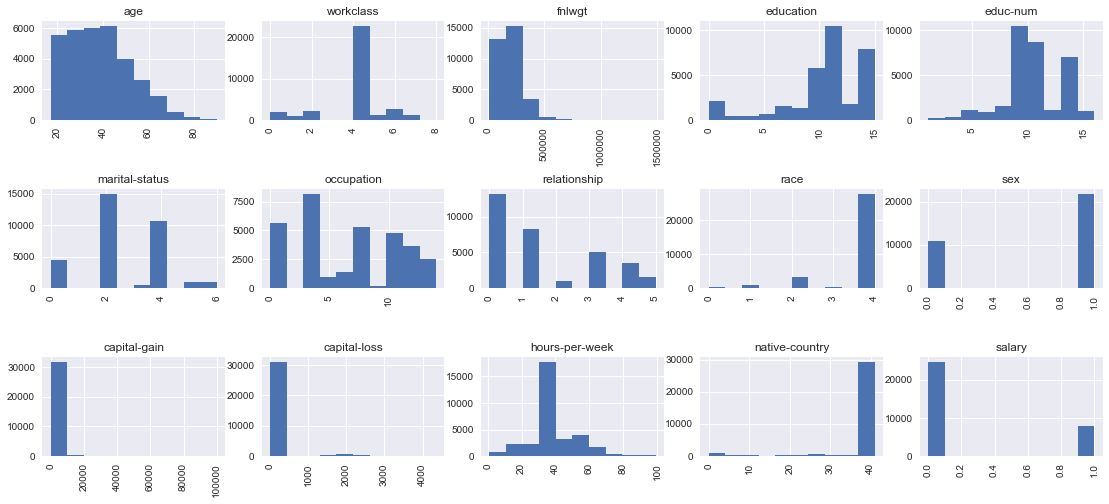

In [12]:
fig = plt.figure(figsize=(19,8))
cols = 5
rows = np.ceil(float(encoded_data.shape[1]) / cols)
for i, column in enumerate(encoded_data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    encoded_data[column].hist(axes=ax)
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

### Матрица корреляций

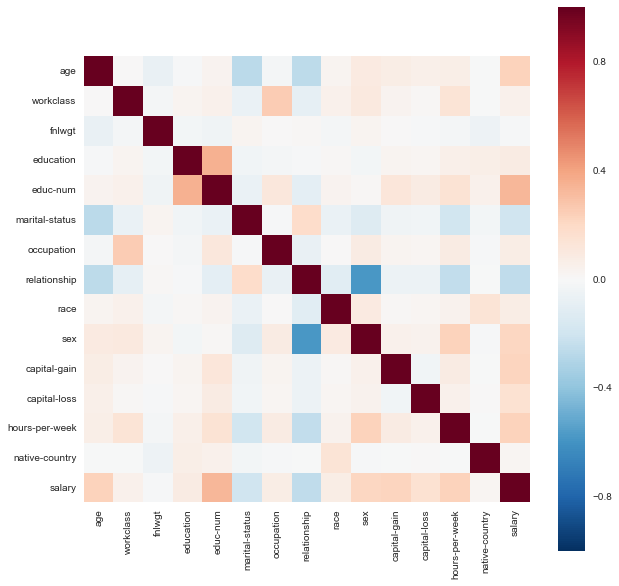

In [13]:
plt.subplots(figsize=(10,10))
encoded_data, encoders = number_encode_features(df)
sns.heatmap(encoded_data.corr(), square=True)
plt.show()

** Вопрос: **
    * Почему не всегда хорошо размечать пропуски аналогично известным значениям атрибутов

В данном датасете пропущенные значения обозначены как " ?".  Удалим из выборки все объекты с пропусками.

In [14]:
df.replace(' ?', np.nan).groupby('workclass').count()[['salary']].index
# df[df['workclass']=='?'].head()

Index([' Federal-gov', ' Local-gov', ' Never-worked', ' Private',
       ' Self-emp-inc', ' Self-emp-not-inc', ' State-gov', ' Without-pay'],
      dtype='object', name='workclass')

In [15]:
df.replace(' ?', np.nan, inplace=True)
df.count()

age               32561
workclass         30725
fnlwgt            32561
education         32561
educ-num          32561
marital-status    32561
occupation        30718
relationship      32561
race              32561
sex               32561
capital-gain      32561
capital-loss      32561
hours-per-week    32561
native-country    31978
salary            32561
dtype: int64

Видим, что признаки workclass, occupation и naitove-country имеют пропуски. Удалим все объекты с пропусками из выборки

In [16]:
df = df.dropna()
df.count()

age               30162
workclass         30162
fnlwgt            30162
education         30162
educ-num          30162
marital-status    30162
occupation        30162
relationship      30162
race              30162
sex               30162
capital-gain      30162
capital-loss      30162
hours-per-week    30162
native-country    30162
salary            30162
dtype: int64

** Вопрос: **
    * Почему не всегда правильно использовать перекодированные категориальные признаки (на примере kNN)?
    
** Предобработка данных: **
     - разметка целевой переменной
     - оставляем только числовые признаки

In [25]:
df_prc = df.copy()
df_prc['salary'] = df['salary'].apply((lambda x: x==' >50K'))
df_prc.head()

,age,workclass,fnlwgt,education,educ-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,False
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,False
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,False
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,False
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,False


In [18]:
# числовые признаки
df._get_numeric_data().columns

Index(['age', 'fnlwgt', 'educ-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')

In [19]:
# Найдём категориальные признаки
Categorical_cols = list(set(df.columns)- set(df._get_numeric_data().columns))

In [20]:
X = np.array(df_prc[df._get_numeric_data().columns])
# y = np.array(df_prc['salary'], dtype='int')
y = encoders['salary'].transform(df['salary'])

------------------------------
# Масштабирование признаков

** Воппрос** 
* Почему для данного датасета может быть полезно привести все признаки к значениями от 0 до 1, для того чтобы использовать kNN в качестве классификатора? 

В качестве классификатора используем kNN, признаки: число соседей (*n_neighbors*) и метрика (*metrics*).


Подберём оптимальные значения указанных гиперпараметров

In [21]:
def grid_plot(x, y, x_label, title, y_label='roc_auc'):
    plt.figure(figsize=(12, 6))
    plt.grid(True)
    plt.plot(x, y, 'go-')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

In [22]:
knn = KNeighborsClassifier()

### Подбор параметра n_neighbors для KNeighborsClassifier

In [23]:
knn_grid = {'n_neighbors': np.array(np.linspace(2, 100, 10), dtype='int')}
gs = GridSearchCV(knn, knn_grid, cv=5)
gs.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([  2,  12,  23,  34,  45,  56,  67,  78,  89, 100])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

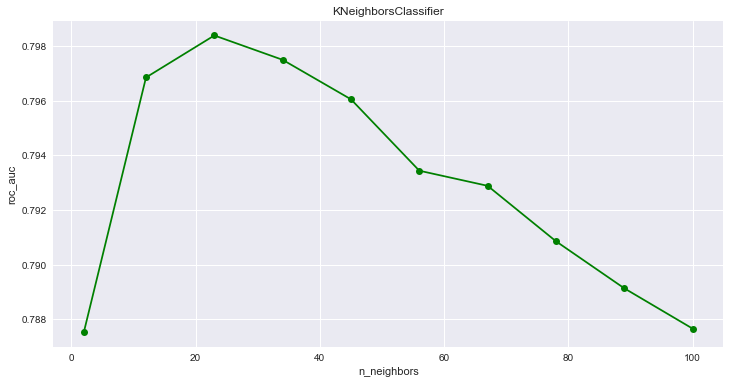

In [144]:
grid_plot(knn_grid['n_neighbors'], gs.cv_results_['mean_test_score'], 'n_neighbors', 'KNeighborsClassifier')

In [154]:
knn_grid = {'n_neighbors': np.array(np.linspace(15, 35, 11), dtype='int')}
gs = GridSearchCV(knn, knn_grid, cv=10)
gs.fit(X, y)
gs.best_params_, gs.best_score_

({'n_neighbors': 29}, 0.79936119898037528)

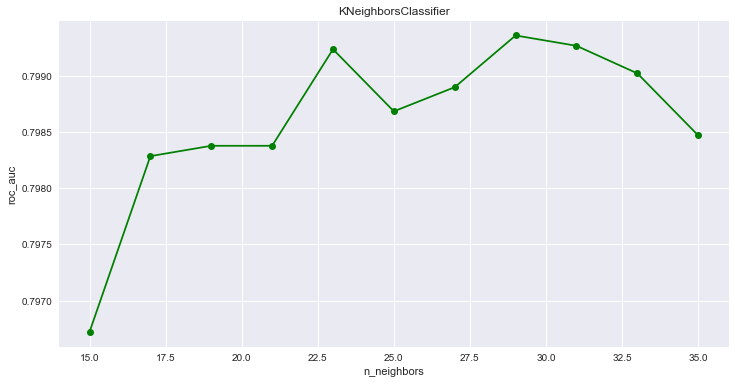

In [155]:
grid_plot(knn_grid['n_neighbors'], gs.cv_results_['mean_test_score'], 'n_neighbors', 'KNeighborsClassifier')

Масштабирование признаков можно выполнить, например, одним из следующих способов способами:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака

In [152]:
from sklearn.preprocessing import scale
X_scaled = scale(np.array(X, dtype='float'), with_std=True, with_mean=False)

In [153]:
X_scaled

array([[ 2.85919077,  0.73441219,  5.05309476,  0.29437338,  0.        ,
         3.23959063],
       [ 3.6656292 ,  0.78931594,  5.05309476,  0.        ,  0.        ,
         1.05286695],
       [ 2.78587819,  2.04310144,  3.49829637,  0.        ,  0.        ,
         3.23959063],
       ..., 
       [ 4.25212987,  1.43924552,  3.49829637,  0.        ,  0.        ,
         3.23959063],
       [ 1.61287685,  1.90898282,  3.49829637,  0.        ,  0.        ,
         1.61979531],
       [ 3.81225436,  2.72791551,  3.49829637,  2.03434482,  0.        ,
         3.23959063]])

### Подборка параметра n_neighbors для KNeighborsClassifier при нормированных признаках

{'n_neighbors': 67} 0.822087773717


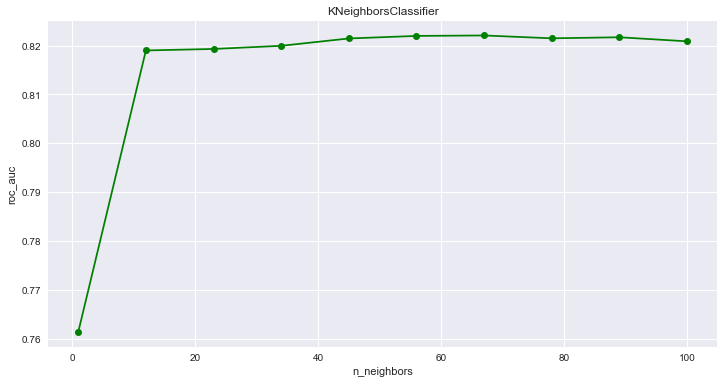

In [161]:
grid = {'n_neighbors': np.array(np.linspace(1, 100, 10), dtype='int')}
gs = GridSearchCV(knn, grid, cv=5, n_jobs=5)
gs.fit(X_scaled, y)
print(gs.best_params_, gs.best_score_)
grid_plot(grid['n_neighbors'], gs.cv_results_['mean_test_score'], 'n_neighbors', 'KNeighborsClassifier')

{'n_neighbors': 59} 0.822916986579


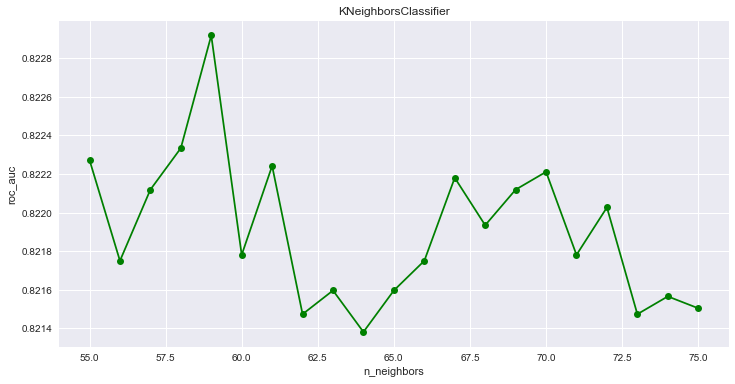

In [164]:
# grid = {'n_neighbors': np.array(np.linspace(55, 75, 21), dtype='int')}
# gs = GridSearchCV(knn, grid, cv=10, n_jobs=5)
# gs.fit(X_scaled, y)
print(gs.best_params_, gs.best_score_)
grid_plot(grid['n_neighbors'], gs.cv_results_['mean_test_score'], 'n_neighbors', 'KNeighborsClassifier')

** Вопрос ** 
 * Увеличилась ли точность классификации после нормировки?

## Добавление категориальных признаков в модели
** Вопрос **
* Как добавить категориальные признаки?

In [11]:
df_cat = pd.concat([X, pd.get_dummies(df_prc[['education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']]) ],
          axis=1)
df_cat.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,education_10th,education_11th,education_12th,education_1st-4th,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,34,284843,9,594,0,60,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,40,190290,10,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,36,177858,13,0,0,40,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
3,22,184756,10,0,0,30,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
4,47,149700,13,15024,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


----------------------------------------
# Отбор признаков

** Вопросы** 
 * Опишите методы отбора признаков 
     - ADD-DELL
     - Перебор в ширину, перебор в глубину
     - Генетический алгоритм
     - Случайный алгоритм

<h1 align="center"> Метрики </h1> 
# Метрики для задачи классификации
### Accuracy

### Поделим выборку на train/test

In [26]:
X_train, X_test, y_tain, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

### Используем 2 классификаторва 
- умный kNN
- глупый -- DummyClassifier (самый популярный класс)

In [27]:
knn = KNeighborsClassifier(n_neighbors=29) 
clf_knn = knn.fit(X_train, y_tain)
clf_mp = dummy.DummyClassifier("most_frequent").fit(X_train, y_tain)

In [28]:
y_knn = clf_knn.predict(X_test)
y_mp = clf_mp.predict(X_test)

In [29]:
y_knn

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [30]:
y_mp

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [31]:
y_test

array([1, 0, 1, ..., 0, 0, 0], dtype=int64)

### $$Accuracy = \frac{\sum_{x_i, y_i \in (X, Y)} I(y(x_i) = y_i)}{|(X, Y)|} = \frac{num~right~classified~obj}{num~all~obj}$$

In [32]:
print ('knn =', metrics.accuracy_score(y_test, y_knn), 'mp =', metrics.accuracy_score(y_test, y_mp))

knn = 0.784709664456 mp = 0.747438215793


** Вопросы **
* На самом ли деле kNN выдает настолько плох?
* Какую использовать метрику точности предсказаний при несбалансированных классах?

### Conf-matrix

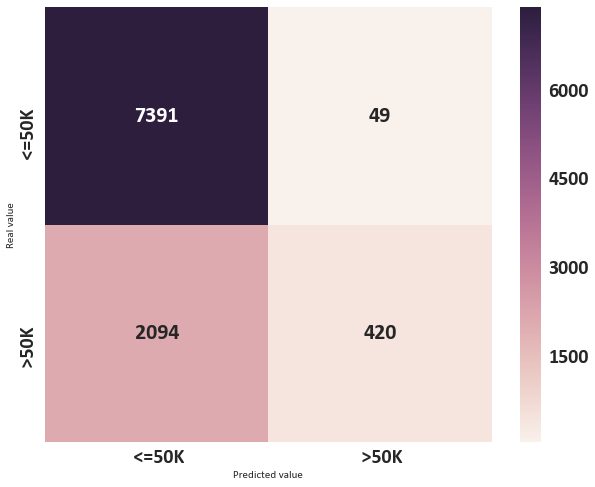

In [33]:
fig = plt.figure(figsize=(10,8))
nn_mtx = metrics.confusion_matrix(y_test, y_knn)

font = {'family' : 'Calibri', 'weight' : 'bold', 'size'   :22}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
sns.heatmap(nn_mtx, annot=True, fmt="d", 
            xticklabels=encoders["salary"].classes_, 
            yticklabels=encoders["salary"].classes_)
plt.ylabel("Real value")
plt.xlabel("Predicted value")

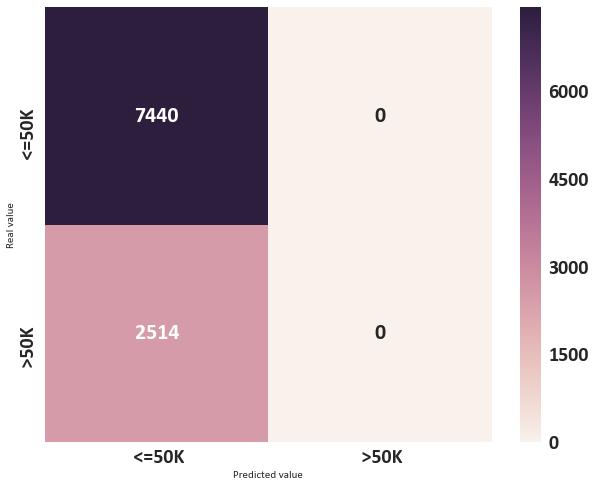

In [34]:
mp_mtx = metrics.confusion_matrix(y_test, y_mp)

font = {'family' : 'Calibri', 'weight' : 'bold', 'size'   :22}
matplotlib.rc('font', **font)
fig = plt.figure(figsize=(10,8))
sns.heatmap(mp_mtx, annot=True, fmt="d", 
            xticklabels=encoders["salary"].classes_, 
            yticklabels=encoders["salary"].classes_)
plt.ylabel("Real value")
plt.xlabel("Predicted value")

### Precision

## $$Precision = \frac{TP}{TP + FP}$$

In [35]:
print ('knn =', metrics.precision_score(y_test, y_knn), 'mp =', metrics.precision_score(y_test, y_mp))

knn = 0.89552238806 mp = 0.0


C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


** Вопрос: **
* Приведите пример работы классификатора когда precition большой а классификатор работает плохо?

### Recall

## $$Recall = \frac{TP}{TP + FN}$$

In [49]:
print ('knn =', metrics.recall_score(y_test, y_knn), 'mp =', metrics.recall_score(y_test, y_mp))

knn = 0.167064439141 mp = 0.0


** Вопрос: ** 
* Приведите пример работы классификатора когда recall большой а классификатор работает плохо?

### F1

Что важнее, точность или полнота? Какое среднее выбрать?

## $$F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$$

** Вопросы: ** 
* Как взвесить Precision и Recall?
    - Среднее арифметичиское плохо: (p=0.5, r=0.5) должно быть лучше чем (p=1, r=0), 
    - Лучше минимум, но при равной точности должен побеждать классфикатор с большей полнотой
    - Гармоничиское среднее, сглаженный минимум

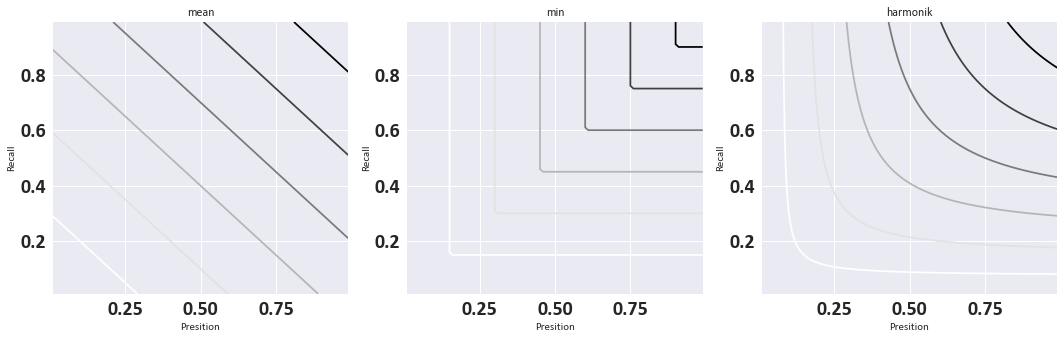

In [50]:
fig, axs = plt.subplots(figsize=(18, 5), ncols=3)

x_, y_ = np.arange(0.01, 1, 0.01), np.arange(0.01, 1, 0.01)
X, Y = np.meshgrid(x_, y_)

Z = [[0.5*x + 0.5*y  for x in x_] for y in y_]
axs[0].contour(X, Y, Z)
axs[0].set_title('mean')
axs[0].set_xlabel('Presition')
axs[0].set_ylabel('Recall')

Z = [[min(x, y)  for x in x_] for y in y_]
axs[1].contour(X, Y, Z)
axs[1].set_title('min')
axs[1].set_xlabel('Presition')
axs[1].set_ylabel('Recall')


Z = [[scipy.stats.hmean([x, y])  for x in x_] for y in y_]
axs[2].contour(X, Y, Z)
axs[2].set_title('harmonik')
axs[2].set_xlabel('Presition')
axs[2].set_ylabel('Recall')

In [51]:
print ('knn =', metrics.f1_score(y_test, y_knn), 'mp =', metrics.f1_score(y_test, y_mp))

knn = 0.281595709018 mp = 0.0


C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


# <span style="color:orange"> Multiclass Precision-Recall </span>(опционально)

#### Загрузим датасет с тремя классами

In [52]:
df_iris = sns.load_dataset("iris")
df_iris = df_iris.sample(n=150)

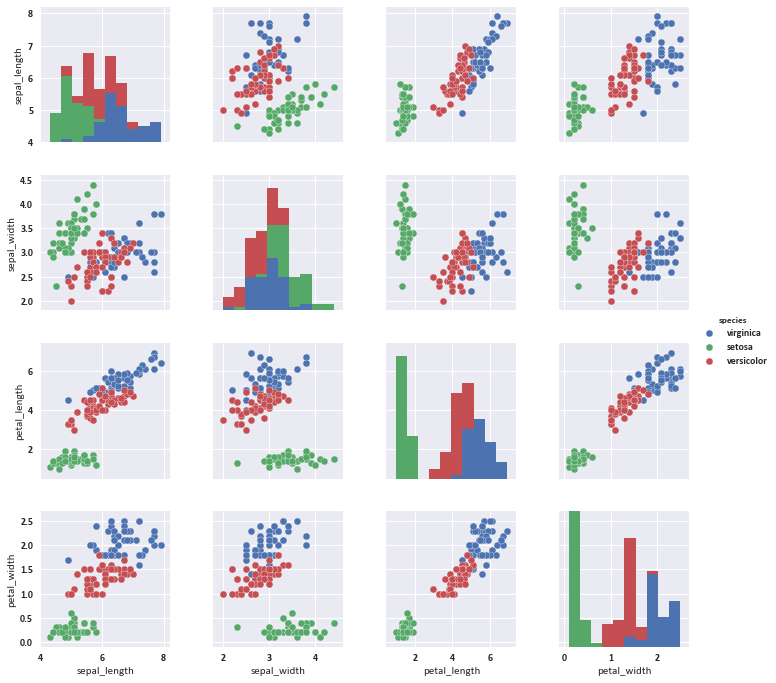

In [53]:
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)
sns.pairplot(df_iris, hue="species")

In [54]:
df_iris, encoders = number_encode_features(df_iris)
iris_X, iris_y = df_iris[df_iris.columns[:-1]].values, df_iris[df_iris.columns[-1]].values

iris_X_train, iris_y_tain = iris_X[:30], iris_y[:30]
iris_X_test, iris_y_test = iris_X[40:], iris_y[40:]

In [55]:
df_iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
142,5.8,2.7,5.1,1.9,2
16,5.4,3.9,1.3,0.4,0
86,6.7,3.1,4.7,1.5,1
93,5.0,2.3,3.3,1.0,1
118,7.7,2.6,6.9,2.3,2


In [56]:
iris_clf_knn = KNeighborsClassifier().fit(iris_X_train, iris_y_tain)
iris_clf_mp = dummy.DummyClassifier("most_frequent").fit(iris_X_train, iris_y_tain)

In [57]:
iris_y_knn = iris_clf_knn.predict(iris_X_test)
iris_y_mp = iris_clf_mp.predict(iris_X_test)

Пусть выборка состоит из K классов. Рассмотрим K двухклассовых задач, каждая из которых заключается в отделении своего класса от остальных, то есть целевые значения для k-й задаче вычисляются как $y_{ik} = [yi = k]$. Для каждой из них можно вычислить различные характеристики (TP, FP, и т.д.) алгоритма $a_k(x) = [a(x) = k]$.

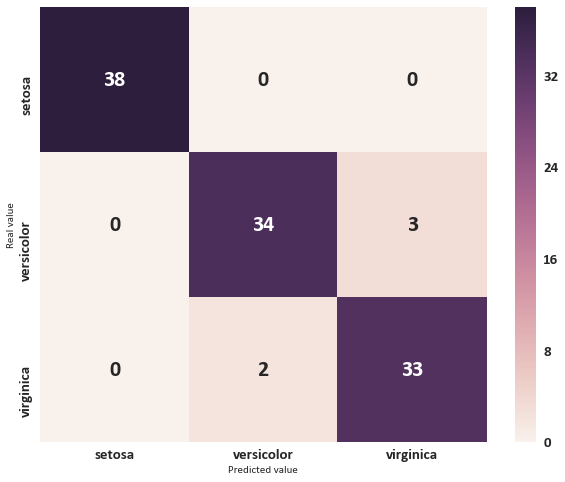

In [58]:
mp_mtx = metrics.confusion_matrix(iris_y_test, iris_y_knn)

fig = plt.figure(figsize=(10,8))
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
sns.heatmap(mp_mtx, annot=True, fmt="d", 
            xticklabels=encoders["species"].classes_, 
            yticklabels=encoders["species"].classes_)
plt.ylabel("Real value")
plt.xlabel("Predicted value")

**Macro-averaging** -- подсчет TP, FN, TN, FP для каждого класса, а после подсчет точности и полноты.

**Micro-averaging** -- подсчет  точности и полноты для каждого класса, а после подсчет их среденего.

In [59]:
print('для kNN:')
print ('macro = ', metrics.f1_score(iris_y_test, iris_y_knn, average='macro'), ', micro = ', metrics.f1_score(iris_y_test, iris_y_knn, average='micro'))

# 
print('\nдля dummy-classifier:')
iris_y_knn[iris_y_knn==1] = 0
print ('macro = ', metrics.f1_score(iris_y_test, iris_y_knn, average='macro'), ', micro = ', metrics.f1_score(iris_y_test, iris_y_knn, average='micro'))

для kNN:
macro =  0.953694771368 , micro =  0.954545454545

для dummy-classifier:
macro =  0.53604963112 , micro =  0.645454545455


C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# AUC-ROC

In [80]:
clf_knn = neighbors.KNeighborsClassifier(n_neighbors=29).fit(X_train, y_tain)
clf_mp = dummy.DummyClassifier("most_frequent").fit(X_train, y_tain)

In [81]:
y_knn = clf_knn.predict(X_test)
y_mp = clf_mp.predict(X_test)

ROC AUC = 0.5802


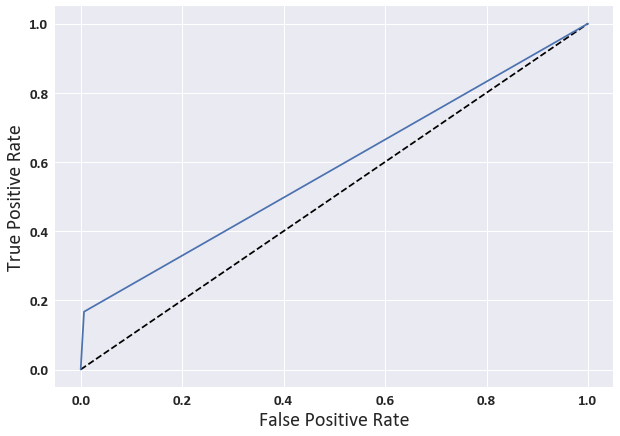

In [90]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_knn)
pylab.figure(figsize=(10, 7))
pylab.plot([0, 1], [0, 1], 'k--')
pylab.plot(fpr, tpr)
print ('ROC AUC = {0:.4f}'.format(metrics.auc(fpr, tpr)))
plt.ylabel("True Positive Rate", fontsize=20)
plt.xlabel("False Positive Rate", fontsize=20)

ROC AUC = 0.5000


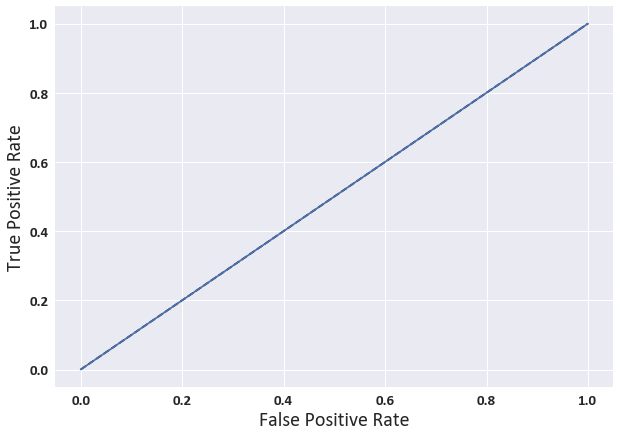

In [89]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_mp)
pylab.figure(figsize=(10, 7))
pylab.plot([0, 1], [0, 1], 'k--')
pylab.plot(fpr, tpr)
print ('ROC AUC = {0:.4f}'.format(metrics.auc(fpr, tpr)))
plt.ylabel("True Positive Rate", fontsize=20)
plt.xlabel("False Positive Rate", fontsize=20)

** Вопрос **
* Когда AUC большой при плохой работе классификатора?

# PR AUC

PR AUC = 0.3839


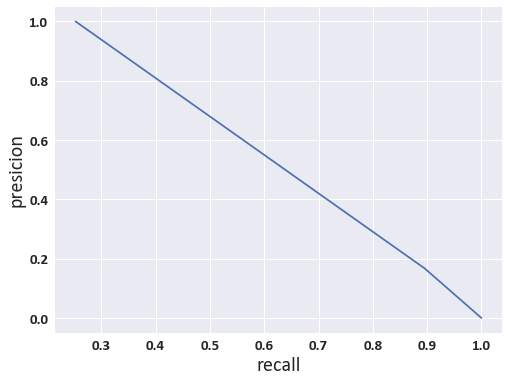

In [88]:
pres, rec, _ = metrics.precision_recall_curve(y_test, y_knn)
pylab.figure(figsize=(8, 6))
pylab.plot(pres, rec)
pylab.ylabel('presicion', fontsize=20)
pylab.xlabel('recall', fontsize=20)
print ('PR AUC = {0:.4f}'.format(metrics.auc(pres, rec)))

In [268]:
pres, rec

(array([ 0.2372976 ,  0.2806532 ,  0.3766803 ,  0.55739972,  0.79148311,
         0.9529703 ,  1.        ]),
 array([ 1.        ,  0.79529412,  0.5054902 ,  0.31607843,  0.21137255,
         0.15098039,  0.        ]))

PR AUC = 0.2525


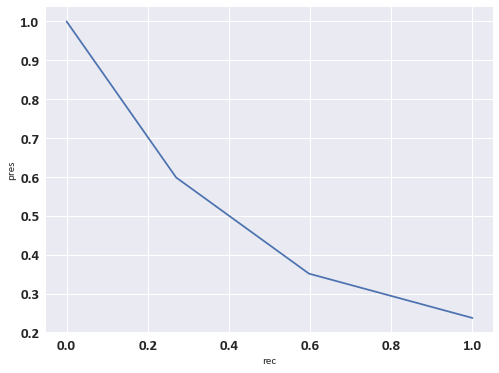

In [270]:
pres, rec, _ = metrics.precision_recall_curve(y_test, y_mp)
pylab.figure(figsize=(8, 6))
pylab.plot(rec, pres)
pylab.ylabel('pres')
pylab.xlabel('rec')
print( 'PR AUC = {0:.4f}'.format(metrics.auc(pres, rec)))

Когда PR кривая не адекватна?

# Метрики для задачи рагрессии

Data: https://archive.ics.uci.edu/ml/datasets/Wine+Quality

In [93]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', header=0, sep=';')

In [94]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


<function print>

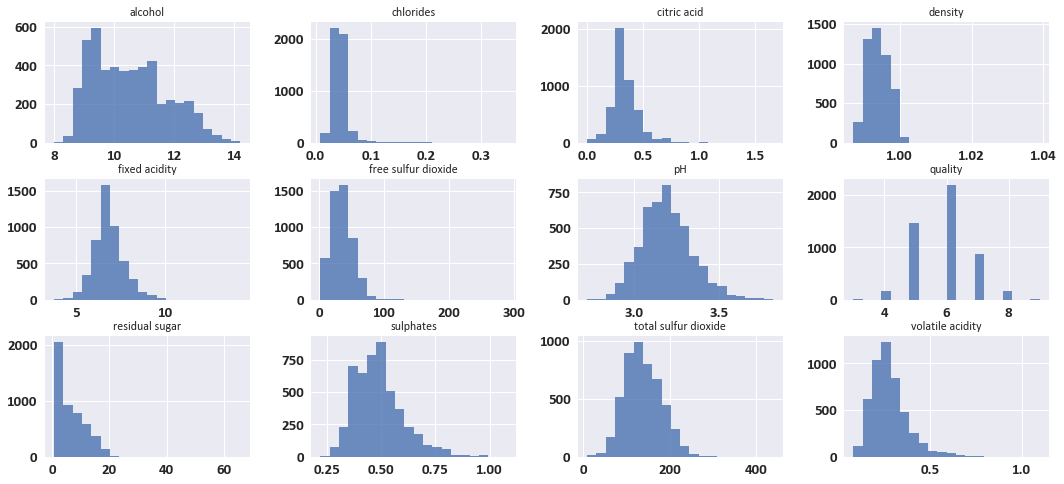

In [95]:
df.hist(figsize=(18, 8), layout=(3,4), bins=20, alpha=0.8)
print 

In [96]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('quality', axis=1), df.quality, test_size=0.33, random_state=42)

In [97]:
X_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
3167,5.6,0.28,0.40,6.1,0.034,36.0,118.0,0.99144,3.21,0.43,12.1
324,8.3,0.41,0.51,2.0,0.046,11.0,207.0,0.99300,3.02,0.55,11.4
4731,5.3,0.31,0.38,10.5,0.031,53.0,140.0,0.99321,3.34,0.46,11.7
2305,7.0,0.36,0.30,5.0,0.040,40.0,143.0,0.99173,3.33,0.42,12.2
1777,6.5,0.18,0.26,1.4,0.041,40.0,141.0,0.99410,3.34,0.72,9.5


In [98]:
y_train.head()

3167    7
324     5
4731    6
2305    7
1777    6
Name: quality, dtype: int64

In [100]:
print (X_train.shape, X_test.shape)
print (y_train.shape, y_test.shape)

(3281, 11) (1617, 11)
(3281,) (1617,)


In [101]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [102]:
# Create dummy regression object
d_regr = dummy.DummyRegressor(strategy='mean')

# Train the model using the training sets
d_regr.fit(X_train, y_train)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [103]:
predictions = regr.predict(X_test)

In [104]:
d_predictions = d_regr.predict(X_test)

In [106]:
print (predictions.shape, '\t', predictions[0:5])

(1617,) 	 [ 6.37886848  6.3994996   6.40362171  5.82459689  6.45383134]


In [107]:
print (d_predictions.shape, '\t', d_predictions[0:5])

(1617,) 	 [ 5.86863761  5.86863761  5.86863761  5.86863761  5.86863761]


(array([ 0.00944673,  0.01417009,  0.00944673,  0.02834018,  0.04251027,
         0.03306354,  0.04723363,  0.12280745,  0.12280745,  0.11808409,
         0.13225418,  0.18893454,  0.27395508,  0.35425226,  0.45816626,
         0.42510271,  0.46761298,  0.50067653,  0.48178307,  0.55735689,
         0.63765407,  0.5431868 ,  0.54791016,  0.42982608,  0.34008217,
         0.23616817,  0.1417009 ,  0.08502054,  0.07557382,  0.03778691,
         0.04723363,  0.01889345,  0.02834018,  0.02361682,  0.01417009,
         0.00472336,  0.01417009,  0.00472336,  0.        ,  0.        ,
         0.        ,  0.00472336,  0.        ,  0.00472336,  0.00472336,
         0.        ,  0.        ,  0.        ,  0.        ,  0.00472336]),
 array([-2.45820085, -2.32727102, -2.19634119, -2.06541135, -1.93448152,
        -1.80355169, -1.67262186, -1.54169202, -1.41076219, -1.27983236,
        -1.14890252, -1.01797269, -0.88704286, -0.75611303, -0.62518319,
        -0.49425336, -0.36332353, -0.23239369, -0

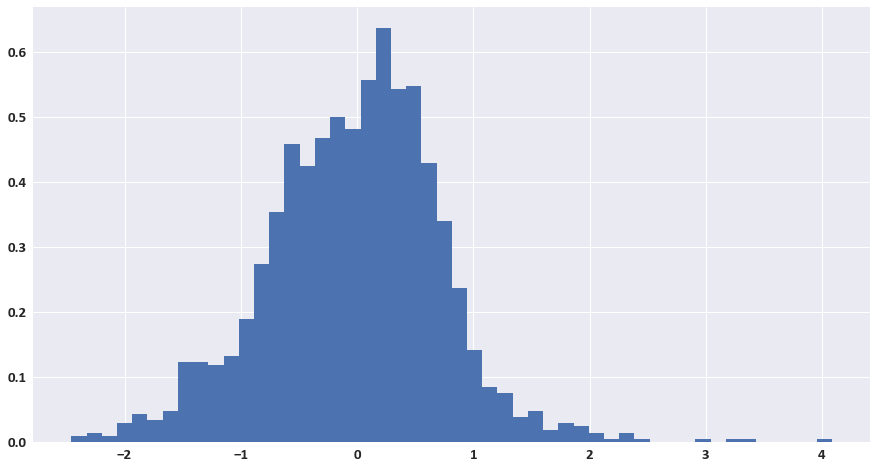

In [109]:
rem = predictions - y_test
pylab.figure(figsize=(15, 8))
plt.hist(rem, bins=50, normed=True)

### Mean Square Error 

## $$ MSE(y, \hat y) = \frac{1}{n_{samples}} \sum_{i=1}^{n_{samples}} ( y_i - \hat y_i )^2 $$

In [111]:
mse = metrics.mean_squared_error(y_test, predictions)
d_mse = metrics.mean_squared_error(y_test, d_predictions)

print ("MSE,  LR = {0:.4}, Dummy = {1:0.4}".format(mse, d_mse))

MSE,  LR = 0.5576, Dummy = 0.7638


In [112]:
rmse = np.sqrt(mse)
d_rmse = np.sqrt(d_mse)

print( "RMSE / LR = {0:.4}, Dummy = {1:0.4}".format(rmse, d_rmse))

RMSE / LR = 0.7467, Dummy = 0.8739


### Mean Absolute Error 

## $$ MAE(y, \hat y) = \frac{1}{n_{samples}} \sum_{i=1}^{n_{samples}} | y_i - \hat y_i | $$

In [113]:
mae = metrics.mean_absolute_error(y_test, predictions)
d_mae = metrics.mean_absolute_error(y_test, d_predictions)

print( "MAE / LR = {0:.4}, Dummy = {1:0.4}".format(mae, d_mae))

MAE / LR = 0.5806, Dummy = 0.6663


### Median Absolute Error 

## $$ MedAE(y, \hat y) = median( | y_1 - \hat y_1 |, ..., | y_n - \hat y_n | ) $$

In [115]:
medae = metrics.median_absolute_error(y_test, predictions)
d_medae = metrics.median_absolute_error(y_test, d_predictions)

print ("MedAE / LR = {0:.4}, Dummy = {1:0.4}".format(medae, d_medae))

MedAE / LR = 0.481, Dummy = 0.8686


### R² score, the coefficient of determination

## $$ R^2(y, \hat y) = 1 -  \frac{\sum_{i=1}^{n_{samples}} ( y_i - \hat y_i )^2}{\sum_{i=1}^{n_{samples}} {( y_i - \bar y_i )^2}} $$

## $ \bar y = \frac{1}{n_{samples}} \sum_{i=1}^{n_{samples}} y_i $

In [117]:
r2 = metrics.r2_score(y_test, predictions)
d_r2 = metrics.r2_score(y_test, d_predictions)

print ("R2 score / LR = {0:.4}, Dummy = {1:0.4}".format(r2, d_r2))

R2 score / LR = 0.2692, Dummy = -0.001034


<b>Как интерпретировать MSE, RMSE, MAE, MedAE?</b>

# Интепретация метрик с вероятностной точки зрения

#### Функционал среднего риска
$$R(a) = \sum\limits_{X}\sum\limits_{Y}\lambda_{ya(x)}P\left(y|x\right)p(x)dx=\int\limits_{X}\sum\limits_{Y}\lambda_{ya(x)}P\left(y|x\right)p(x)dx $$
* paragraph 2.1 http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf

** Задача 1** 
<img src='img/Task2.png'>

** Задача 2** 
<img src='img/Task3.png'>

<h1 align="center"> Bias-Variance TradeOff </h1> 
# Проблема переобучения

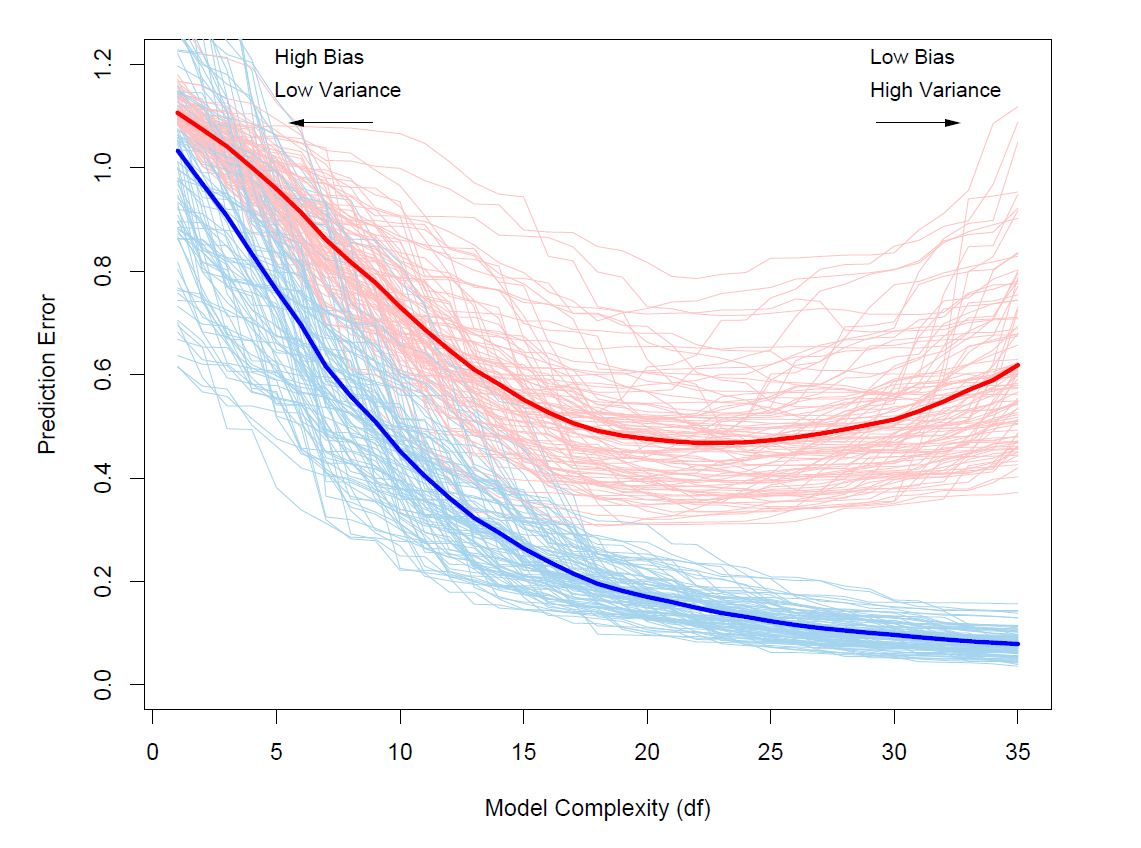

In [51]:
# Overfitting 
Image('pic/CV.jpg', width=700, height=500)

<span style='color: blue, font-size=12pt'> Learing Sample = Train Set = Обучающая выборка </span>  VS
<span style='color: red, font-size=12pt'> Validation Sample = Validation Set = Контрольная выборка </span>

<span style='color: green, font-size=12pt'> Переобучение - это явление (эффект), связанное с тем, что с ростом сложности семейства алгоритмов будет ухудшаться (с некоторого момента), точность на контрольной выборке.</span>

** Вопросы **
 * В чём причина переобучения?
 * Можно ли ожидать, что с ростом сложности модели ошибка на контрольной (велидационной) выборке будет только расти (неуменьшаться)?

# Идея разложения ошибки на bias и variance

** Bias Variance Idea **
   * Given a model $a_{LS}$ built from learning sample $LS$.
    - Its generalization error (useful for model assessment):
$$ Err_{LS}=E_{X,Y}\{\mathcal L(y, a_{LS})\}$$

   * Given a learning algorithm $\mu$ trained on $LS$ of size $\ell$
     - Its error (useful to describe learning algorithm):
    $E_{LS} {Err_{LS} }=E_{LS} \left\{E_{X,Y}\{\mathcal L(y, a_{LS})\}\right\}$

<img src='img/BVIdea.jpg', Width=600>

## БЮВывод для регрессии при квадратичной функции потерь  
* simple regression model $Err_{LS} = E_y \left\{(y-\hat{y})^2\right\}$:
* a good algorithm should minimize an error not only on one $LS$, but in average over all $LS$ of size $\ell$:

\begin{equation}
    \begin{split}
        &  E_{LS} \left\{E_{Y}\{(y - \hat{y})^2\}\right\} = E_{LS} \left\{E_{Y}\{(y - E_Y\{y\} + E_Y\{y\} - \hat{y})^2\}\right\} = \\
          = & E_{LS} \left\{E_{Y}\{(y - E_Y\{y\})^2\}\right\} + E_{LS} \left\{E_{Y}\{(E_Y\{y\} - \hat{y})^2\}\right\}+
        2 E_{LS} \left\{E_{Y}\{(y - E_Y\{y\}) (E_Y\{y\} - \hat{y})\}\right\} = \\
          = & E_{Y}\{(y - E_Y\{y\})^2\} + E_{LS} \left\{(E_Y\{y\} - \hat{y})^2\right\}
        + 2 E_{LS} \left\{E_{Y}\{(y - E_Y\{y\}) (E_Y\{y\} - \hat{y})\}\right\} =\\
         & = \color{red}{\underbrace{E_{Y}\{(y - E_Y\{y\})^2\}}_{var_Y\{y\}}} +\color{black}{E_{LS} \left\{(E_Y\{y\} - \hat{y})^2\right\}}
    \end{split}
\end{equation}

\begin{equation}
    \begin{split}
        & E_{LS} \left\{(E_Y\{y\} - \hat{y})^2\right\} = E_{LS} \left\{(E_Y\{y\} - E_{LS}\{\hat{y}\} + E_{LS}\{\hat{y}\} - \hat{y})^2\right\} = \\
        & =E_{LS} \left\{(E_Y\{y\} - E_{LS}\{\hat{y}\})^2\right\} + E_{LS} \left\{(E_{LS}\{\hat{y}\} - \hat{y})^2\right\}
         + E_{LS} \left\{2 (E_Y\{y\} - E_{LS}\{\hat{y}\})(E_{LS}\{\hat{y}\} - \hat{y})\right\} = \\
        & =(E_Y\{y\} - E_{LS}\{\hat{y}\})^2 + E_{LS} \left\{(\hat{y}-E_{LS}\{\hat{y}\})^2\right\} + 2 (E_Y\{y\} - E_{LS}\{\hat{y}\})(E_{LS}\{\hat{y}\} - E_{LS}\{\hat{y}\}) = \\
        & = \color{red}{\underbrace{(E_Y\{y\} - E_{LS}\{\hat{y}\})^2 }_{bias^2}}+ \color{red}{\underbrace{E_{LS} \left\{(\hat{y}-E_{LS}\{\hat{y}\})^2\right\}}_{variance}}
    \end{split}
\end{equation}

* более полная версия для регрессии и knn: https://github.com/ml-mipt/ml-mipt-part1/blob/master/2017/seminars/03-pandas/bias_variance.pdf

** Задача **:
Предсказать средний рост группы 59x , которая поступит на физтех в 2025 году, зная рост всех 59x групп прошлых лет. 

Решение: используется 2 модели

## 1) $$\hat{y}=\frac{1}{l}\sum_{i=1}^l y_i$$
## 2) $$\hat{y}=\frac{\lambda\cdot 180+\sum_{i=1}^l y_i}{\lambda+l}$$

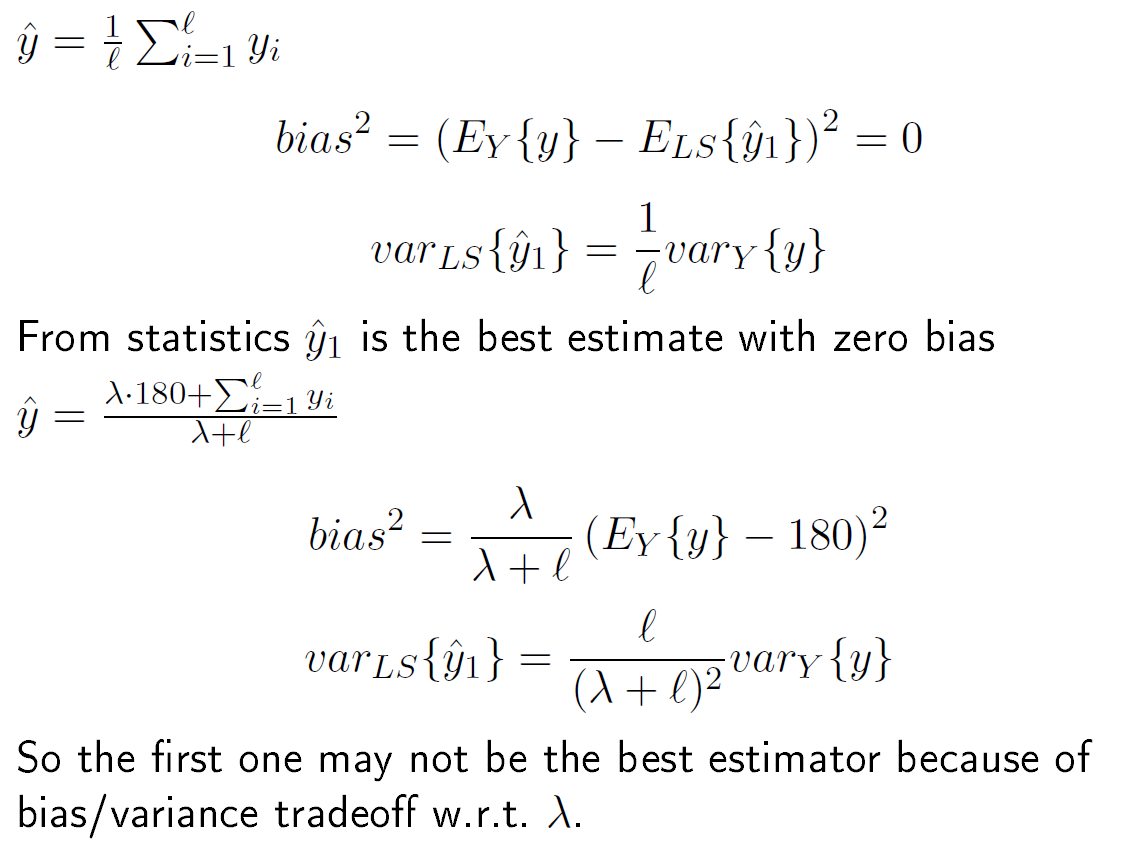

In [62]:
Image('pic/BiasVarianceExample.png', width=500, height=500)

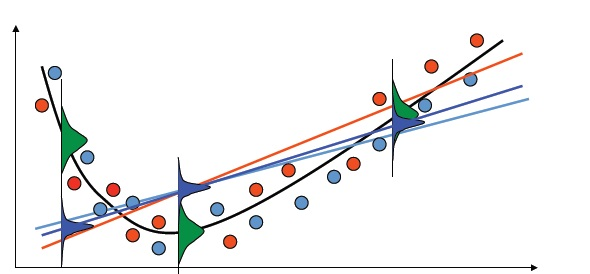

In [63]:
# Underfitting via Bias-Variance approach
Image('pic/Underfitting.jpg')

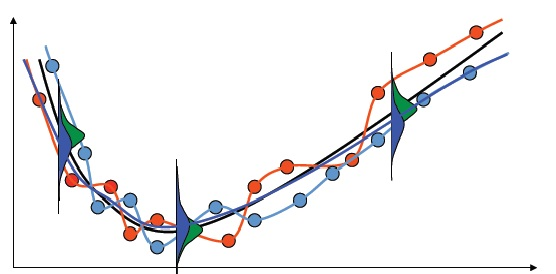

In [65]:
# Overfitting via Bias-Variance approach
Image('pic/Overfitting1.jpg')

------------------------------------
# Bias и Variance

**Bias-Variance ** в зависимости от сложности модели 
<img src='img/BiasVariance.jpg' Width=500>

* ** для kNN** в зависимости от $k$

<img src='img/BV_knn.png', width=500, height=500>


* ** для LR ** в зависимости от размера выборки 
<img src='img/BV_LR.png', width=700, height=700>

<h1 align="center"> Заключение </h1>
* Разные метрики проводят к существенно разным ответам
* Bias-variance tradeoff - один из возможных взглядов на проблему переобучения
    - помогает понять, как работают алгоритмы ML


* <a href = "https://github.com/ml-mipt/ml-mipt-part1/blob/master/2018/hw/hw1/task1.ipynb"> HW#1 <a>
     - <span style='color:blue; font-size:10pt'> Обратите внимание на правила сдачи ДЗ! </span>

# Обратная связь
  * оцените <a href="https://goo.gl/forms/kYZuyAQLuwo8szce2"> семинар </a>
  * оцените <a href="https://goo.gl/forms/zeZiu1fSgrpPGp6T2"> лекцию </a>